

Training a PyTorch model with JAX
=====================




Introduction
------------

This tutorial notebook is adapted from https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html

It will keep the most PyTorch code unchanged (especially the model definition),
and will replace the standard PyTorch train loop (`loss.backward()` + `optimizer.step()` pattern)
with a JAX train loop (`jax.grad` followed by `optax.apply_updates`).

The rest of the tutorial, such as data loading, print loss etc. are kept as close to the original as possible.

Dataset and DataLoader
----------------------

The `Dataset` and `DataLoader` classes encapsulate the process of
pulling your data from storage and exposing it to your training loop in
batches.

The `Dataset` is responsible for accessing and processing single
instances of data.

The `DataLoader` pulls instances of data from the `Dataset` (either
automatically or with a sampler that you define), collects them in
batches, and returns them for consumption by your training loop. The
`DataLoader` works with all kinds of datasets, regardless of the type of
data they contain.

For this tutorial, we'll be using the Fashion-MNIST dataset provided by
TorchVision. We use `torchvision.transforms.Normalize()` to zero-center
and normalize the distribution of the image tile content, and download
both training and validation data splits.


In [7]:
# Optional: install dependencies
!pip install matplotlib torch torchax jax optax tensorboard

/Users/hanq/homebrew/Caskroom/miniconda/base/envs/py13/lib/python3.13/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [8]:
# For tips on running notebooks in Google Colab, see
# https://docs.pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


As always, let's visualize the data as a sanity check:


/Users/hanq/homebrew/Caskroom/miniconda/base/envs/py13/lib/python3.13/site-packages/jax/_src/numpy/lax_numpy.py:5943: UserWarning: Explicitly requested dtype int64 requested in arange is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return _arange(start, stop=stop, step=step, dtype=dtype,


Trouser  Pullover  Dress  Sandal


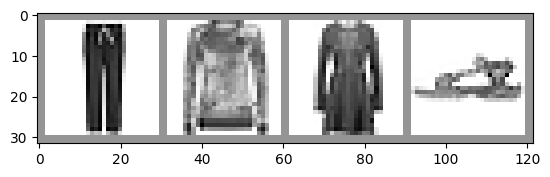

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

The Model
=========

The model we'll use in this example is a variant of LeNet-5 - it should
be familiar if you've watched the previous videos in this series.


In [11]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()

In [12]:
model(images)

tensor([[ 0.0671, -0.0466, -0.0187,  0.0472, -0.1055, -0.1039, -0.0175, -0.0597,
          0.0859, -0.0092],
        [ 0.0603, -0.0519, -0.0106,  0.0512, -0.0959, -0.1090, -0.0222, -0.0404,
          0.0871, -0.0130],
        [ 0.0552, -0.0521, -0.0264,  0.0484, -0.1110, -0.0977, -0.0239, -0.0368,
          0.0876, -0.0161],
        [ 0.1057, -0.0406, -0.0353,  0.0709, -0.1102, -0.1155,  0.0006, -0.0535,
          0.1068, -0.0352]], grad_fn=<AddmmBackward0>)

Loss Function
=============

For this example, we'll be using a cross-entropy loss. For demonstration
purposes, we'll create batches of dummy output and label values, run
them through the loss function, and examine the result.


In [13]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.9722, 0.7499, 0.2067, 0.3123, 0.9140, 0.1229, 0.4278, 0.6907, 0.1878,
         0.8628],
        [0.6991, 0.8526, 0.1795, 0.6230, 0.0241, 0.8825, 0.6644, 0.4816, 0.4227,
         0.8474],
        [0.5714, 0.0439, 0.7818, 0.1378, 0.3126, 0.8229, 0.8647, 0.2827, 0.8375,
         0.7954],
        [0.2767, 0.4335, 0.3760, 0.5561, 0.9974, 0.8283, 0.0061, 0.2114, 0.1310,
         0.5997]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.374995231628418


## Move model to 'jax' device

In [14]:
import torchax
torchax.enable_globally()
model.to('jax')
images = images.to('jax')
dummy_labels = dummy_labels.to('jax')

Optimizer
=========

For this example, we'll be using simple [optax](https://optax.readthedocs.io/en/latest/getting_started.html)
optimizer.



In [15]:
import optax
start_learning_rate = 1e-3
optimizer = optax.adam(start_learning_rate) 

In [16]:
print(optimizer)


GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x168480f40>, update=<function chain.<locals>.update_fn at 0x168480fe0>)


The Training Loop
=================

Below, we have a function that performs one training epoch.

First, let's articulate what the training step does.

At each training step, we first evaluate the model. the Model is a
function that maps the `(weights, input data)` to `prediction`.

$$ model: (weights, input) \mapsto pred $$

In PyTorch, we can use [torch.func.functional_call](https://docs.pytorch.org/docs/stable/generated/torch.func.functional_call.html) to call a model 
with weights passed in as a paramter.

The loss is a function that takes the prediction, the label to a real number
representing the loss:

$$ loss: (pred, label) \mapsto loss $$

To train the model, we a glorified Gradient Descent (in this case Adam), so
we need to have another function that represent the gradient of the 
loss with respect of weights.

$$ \frac {d loss} {d weights}$$

Finally, the `train_step` itself is a function that takes (weights, optimizer_state, input_data) to
(updated weights, and updated optimizer_states).

We can spell out the individual components of a train loop, and use Python to assemble them together:

In [17]:
weights = model.state_dict()

def run_model_and_loss(weights, inputs, labels):
    # First call the model with passed in weights
    output = torch.func.functional_call(model, weights, args=(inputs, ))
    loss = loss_fn(output, labels)
    return loss

In [18]:
run_model_and_loss(model.state_dict(), images, dummy_labels)

Tensor(<class 'jaxlib._jax.ArrayImpl'> 2.33033)

Now let's define the gradient function of it. In JAX, one would use `jax.jit`. 
However, `jax.jit` need to take a JAX function (function that takes jax.Array as inputs and outputs) as 
argument, and here `run_model_and_loss` takes torch.Tensor as inputs / outputs.

One way to solve this issue is to use `jax_view` from the [torchax.interop module](https://github.com/google/torchax/blob/main/torchax/interop.py)

`jax_view` converts a torch function to a jax function.

`torchax` has common JAX functions wrapped in the [so they work with torch-functions as well.
in this case, we will use `jax_value_and_grad`.

In [19]:
from torchax.interop import jax_view
import jax

grad_fn_jax = jax.grad( jax_view(run_model_and_loss))

grad_fn_jax(jax_view(weights), jax_view(images), jax_view(dummy_labels)).keys()

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])

Note that above `grad_fn_jax` is the gradient of `jax_view(run_model_and_loss)` and is a jax function.

if instead we wish to make a it into a torch function, we can use `torch_view` on it and it will
become a function that takes torch tensors and returns torch tensors.

In fact, the pattern of calling, `jax_view` + `jax.value_and_grad` + `torch_view` is common enough that
we provided this very wraper as `torchax.interop.jax_value_and_grad` below

In [20]:
grad_fn = torchax.interop.jax_value_and_grad(run_model_and_loss)




Now let's assemble the train loop:

In [21]:
# Initialize optimizer
from torchax.interop import call_jax

# Initialize optimizer, we need to call optimizer.init, but
# it is a JAX-function (function that takes jax arrays as input),
# so we use call_jax to pass it torch values:

opt_state = call_jax(optimizer.init, weights)


def train_one_epoch(epoch_index, tb_writer):
    global weights
    global opt_state
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs = inputs.to('jax')
        labels = labels.to('jax')

        # compute gradients
        loss, gradients = grad_fn(weights, inputs, labels)
        # compute updates
        updates, opt_state = call_jax(optimizer.update, gradients, opt_state)
        #apply updates
        weights = call_jax(optax.apply_updates, weights, updates)
        
        # Gather data and report
        running_loss += loss.cpu().item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
        if i > 2000: 
            break
            # NOTE: make it run faster for CI

    return last_loss

In [22]:
weights

OrderedDict([('conv1.weight',
              Tensor(<class 'jaxlib._jax.ArrayImpl'> [[[[-0.01919572  0.08173535  0.11195555 -0.0464663  -0.01724706]
                 [ 0.00474899 -0.09588833 -0.08292859  0.01614468 -0.07575631]
                 [-0.14652589  0.13480428 -0.19805682  0.03487966 -0.15263537]
                 [-0.19650117 -0.03486729 -0.13269444  0.19900253 -0.10203419]
                 [-0.11847182  0.1167357  -0.07137737  0.17127113  0.00041001]]]
              
              
               [[[ 0.0435169  -0.01835244  0.00851111  0.08337722  0.19144812]
                 [-0.00774817 -0.16186371 -0.06935952  0.00296748  0.06117613]
                 [-0.09910274  0.07001872  0.14024901  0.17163089 -0.17241679]
                 [ 0.03131669 -0.07166276 -0.1258725  -0.03829036  0.11497901]
                 [-0.10303264 -0.16092996 -0.00041683  0.14637287  0.05899556]]]
              
              
               [[[ 0.18458724 -0.14367557 -0.02649014  0.17617439  0.08161464

Per-Epoch Activity
==================

There are a couple of things we'll want to do once per epoch:

-   Perform validation by checking our relative loss on a set of data
    that was not used for training, and report this
-   Save a copy of the model

Here, we'll do our reporting in TensorBoard. This will require going to
the command line to start TensorBoard, and opening it in another browser
tab.


In [17]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 2

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to('jax')
            vlabels = vlabels.to('jax')
            model.load_state_dict(weights) # put the trained weight back to test it
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

            if i > 1000:
                break

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()


    epoch_number += 1

EPOCH 1:


/Users/hanq/homebrew/Caskroom/miniconda/base/envs/py13/lib/python3.13/site-packages/jax/_src/numpy/lax_numpy.py:5943: UserWarning: Explicitly requested dtype int64 requested in arange is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return _arange(start, stop=stop, step=step, dtype=dtype,
/Users/hanq/git/qihqi/torchax/torchax/ops/mappings.py:83: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:209.)
  res = tor

  batch 1000 loss: 0.9756997779496014
  batch 2000 loss: 0.6890982975531369
LOSS train 0.6890982975531369 valid Tensor(<class 'jaxlib._jax.ArrayImpl'> 0.65348643)
EPOCH 2:
  batch 1000 loss: 0.5893321642498486
  batch 2000 loss: 0.5676386482019443
LOSS train 0.5676386482019443 valid Tensor(<class 'jaxlib._jax.ArrayImpl'> 0.511011)


## Save the model checkpoint

Currently `torch.save` (which is based on Pickle) are not able to save tensors on 'jax' device. 
Because JAX arrays cannot be pickled.

So now we have 2 strategies for saving:
1. convert the tensors on jax devices to plain JAX arrays; then use flax.checkpoint to save the data. You will get an JAX-style checkpoint (directory) if you do so.
2. convert the tensors from jax devices to CPU torch.Tensor, then use `torch.save`; you will get a regular pickle based checkpoint if you do so.

We recommend 1. and we have provided wrapper in `torchax.save_checkpoint` that does exactly this.

In [18]:
import os
import orbax.checkpoint as ocp
ckpt_dir = ocp.test_utils.erase_and_create_empty('/tmp/my-checkpoints/')
model_path = ckpt_dir / 'state'
torchax.save_checkpoint(weights, model_path, step=1)


In [2]:
!find /tmp/my-checkpoints/


/tmp/my-checkpoints/
/tmp/my-checkpoints/torch_checkpoint.pkl
/tmp/my-checkpoints/state
/tmp/my-checkpoints/state/checkpoint_1
/tmp/my-checkpoints/state/checkpoint_1/_sharding
/tmp/my-checkpoints/state/checkpoint_1/_METADATA
/tmp/my-checkpoints/state/checkpoint_1/_CHECKPOINT_METADATA
/tmp/my-checkpoints/state/checkpoint_1/array_metadatas
/tmp/my-checkpoints/state/checkpoint_1/array_metadatas/process_0
/tmp/my-checkpoints/state/checkpoint_1/manifest.ocdbt
/tmp/my-checkpoints/state/checkpoint_1/d
/tmp/my-checkpoints/state/checkpoint_1/d/64caa9fda45b7e010ab72cc60511e3b4
/tmp/my-checkpoints/state/checkpoint_1/ocdbt.process_0
/tmp/my-checkpoints/state/checkpoint_1/ocdbt.process_0/manifest.ocdbt
/tmp/my-checkpoints/state/checkpoint_1/ocdbt.process_0/d
/tmp/my-checkpoints/state/checkpoint_1/ocdbt.process_0/d/a37364fedb7049546fd77e7acc4bb7a9
/tmp/my-checkpoints/state/checkpoint_1/ocdbt.process_0/d/e52cc72492daf25e6f82c2410145c041
/tmp/my-checkpoints/state/checkpoint_1/ocdbt.process_0/d/40aba93

You can also produce a torch pickle based checkpoint by moving the state_dict to CPU

You can do so with 

In [23]:

cpu_state_dict = jax.tree.map(lambda a: a.jax(), weights)

In [21]:
torch.save(cpu_state_dict, ckpt_dir / 'torch_checkpoint.pkl')

In [1]:
!ls /tmp/my-checkpoints/


state                torch_checkpoint.pkl
